In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import transforms
from transformers import ViTModel, ViTFeatureExtractor
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from PIL import Image

2026-02-05 09:17:32.801840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770283053.031811      33 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770283053.104296      33 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Step 1: Load the Pre-trained Vision Transformer Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224').to(device)
model.eval()  # Set the model to evaluation mode

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

In [3]:
!pip3 install torchinfo


In [4]:
from transformers import ViTModel
from torchinfo import summary

# Load the pre-trained Vision Transformer (ViT) model
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Get the model summary
summary(model, input_size=(1, 3, 224, 224))  # Batch size of 1, RGB channels, 224x224 image


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                             Output Shape              Param #
ViTModel                                           [1, 768]                  --
├─ViTEmbeddings: 1-1                               [1, 197, 768]             152,064
│    └─ViTPatchEmbeddings: 2-1                     [1, 196, 768]             --
│    │    └─Conv2d: 3-1                            [1, 768, 14, 14]          590,592
│    └─Dropout: 2-2                                [1, 197, 768]             --
├─ViTEncoder: 1-2                                  [1, 197, 768]             --
│    └─ModuleList: 2-3                             --                        --
│    │    └─ViTLayer: 3-2                          [1, 197, 768]             7,087,872
│    │    └─ViTLayer: 3-3                          [1, 197, 768]             7,087,872
│    │    └─ViTLayer: 3-4                          [1, 197, 768]             7,087,872
│    │    └─ViTLayer: 3-5                          [1, 197, 768]             7,087,8

In [5]:
# Step 2: Load Images and Prepare Labels  
image_folder = '/kaggle/input/skindatav2/CancerSkin'  # Update with your image folder path  
image_files = os.listdir(image_folder)  
labels = [file.split('_')[0] for file in image_files]  # Assume label is part of the filename  
labels = ['Normal', 'Cancer']
labels
# Step 3: Train-Test Split  
#X_train_paths, X_test_paths, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=42)  
# Example directory structure  
base_dir = '/kaggle/input/skindatav2/CancerSkin'  # Change this to your dataset path  
categories = ['Normal', 'Cancer'] # Define your categories  

image_paths = []  
labels = []  

# Collect all paths and corresponding labels  
for category in categories:  
    category_path = os.path.join(base_dir, category)  
    for filename in os.listdir(category_path):  
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Check for image files  
            image_paths.append(os.path.join(category_path, filename))  
            labels.append(category)  

In [6]:
# Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels


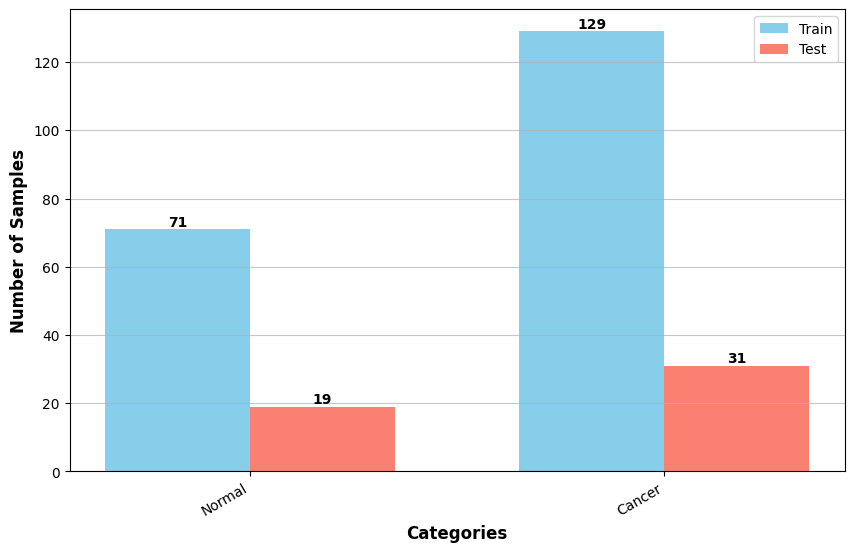

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define categories (class labels)
categories = sorted(set(y_train) | set(y_test))  # Get unique class labels

# Count occurrences of each class
train_counts = [np.count_nonzero(y_train == cls) for cls in categories]
test_counts = [np.count_nonzero(y_test == cls) for cls in categories]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(categories))

# Create bars
train_bars = plt.bar(index, train_counts, bar_width, label='Train', color='skyblue')
test_bars = plt.bar(index + bar_width, test_counts, bar_width, label='Test', color='salmon')

# Add numbers on top of bars
for bars in [train_bars, test_bars]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
categories = ['Normal', 'Cancer']
# Formatting the plot
plt.xlabel('Categories', fontsize=12, fontweight='bold')  # ✅ Label for x-axis
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
#plt.title('Train-Test Split Distribution', fontsize=14, fontweight='bold')
plt.xticks(index + bar_width / 2, categories, rotation=30, ha="right", fontsize=10)  # ✅ Class names added
plt.legend()
plt.grid(axis='y', linestyle='-', alpha=0.7)  # Add horizontal grid lines for better readability

plt.savefig('train_test.png', dpi=300, bbox_inches='tight')  # Save as PNG with high resolution

# Display the plot
plt.show()

**1. Trích xuất đặc trưng của ảnh - Mỗi ảnh sẽ được đại diện bởi 768 giá trị. ** 

In [8]:
import os
import numpy as np
import torch
from PIL import Image, UnidentifiedImageError

def extract_features(image_paths, feature_extractor, model, device):
    features = []
    
    for img_path in image_paths:
        if os.path.isfile(img_path):
            try:
                # Load image and preprocess
                image = Image.open(img_path).convert("RGB")
                inputs = feature_extractor(images=image, return_tensors="pt").to(device)

                # Extract features using Transformer model
                with torch.no_grad():
                    outputs = model(**inputs)

                # Extract CLS token feature vector
                cls_token_feature = outputs.last_hidden_state[:, 0, :]  # CLS token representation

                # Convert to NumPy array
                features.append(cls_token_feature.cpu().numpy().flatten())

            except UnidentifiedImageError:
                print(f"Warning: Unable to identify image file {img_path}. Skipping.")
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
        else:
            print(f"Warning: {img_path} is not a valid file.")

    return np.array(features)

In [9]:
def process_image(img_path):
    """Process a single image and extract features."""
    if not os.path.isfile(img_path):
        print(f"Warning: {img_path} is not a valid file.")
        return None
    
    try:
        # Load and preprocess image
        image = Image.open(img_path).convert("RGB")  # Ensure 3-channel format

        # Extract features
        inputs = feature_extractor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Average pooling over token dimension
        feature_vector = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        return feature_vector.flatten()

    except UnidentifiedImageError:
        print(f"Warning: Unable to identify image file {img_path}. Skipping.")
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

    return None  # Return None for failed cases

def extract_features(image_paths, num_workers=4):
    """Parallel feature extraction."""
    features = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        results = list(executor.map(process_image, image_paths))

    # Remove None values (failed images) and convert to NumPy array
    features = np.array([res for res in results if res is not None])
    return features

In [10]:
import time
start=time.time()
from concurrent.futures import ThreadPoolExecutor
Train_features = extract_features(X_train, num_workers=4)  # Adjust workers based on CPU cores
print(f"Extracted Features Shape: {Train_features.shape}") 
end=time.time()
print('Thoi gian thu thi',end-start)

Extracted Features Shape: (200, 768)
Thoi gian thu thi 3.0209274291992188


In [11]:
# Lưu vào file Excel
df = pd.DataFrame(Train_features)  # Chuyển thành DataFrame
df.to_excel("Train_features.xlsx", index=False)  # Lưu vào tệp Excel

In [12]:
import time
start=time.time()
from concurrent.futures import ThreadPoolExecutor
Test_features = extract_features(X_test, num_workers=4)  # Adjust workers based on CPU cores
print(f"Extracted Features Shape: {Test_features.shape}") 
end=time.time()
print('Thoi gian thu thi',end-start)

Extracted Features Shape: (50, 768)
Thoi gian thu thi 0.8371403217315674


In [ ]:
# Lưu vào file Excel
df2 = pd.DataFrame(Test_features)  # Chuyển thành DataFrame
df2.to_excel("Test_features.xlsx", index=False)  # Lưu vào tệp Excel

**2. Phân loại: Phân pháp Naive bayes nâng cao**

In [13]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KernelDensity
import numpy as np
import time
st=time.time()
class EnhanceBayes:
    def __init__(self, bandwidth=0.05, default_class=None):
        self.bandwidth = bandwidth
        self.kde_models = {}
        self.classes = None
        self.priors = None
        self.default_class = default_class  # Fallback class if no valid prediction

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}
        n_samples = len(y)

        # Calculate prior probabilities
        for c in self.classes:
            self.priors[c] = np.sum(y == c) / n_samples
        
        # Fit KDE for each feature and each class, skip if no samples
        for c in self.classes:
            X_c = X[y == c]
            if X_c.shape[0] == 0:
                print(f"Warning: No samples found for class {c}. Skipping KDE fitting.")
                self.kde_models[c] = None
                continue
            self.kde_models[c] = []
            for feature_idx in range(X.shape[1]):
                kde = KernelDensity(bandwidth=self.bandwidth, kernel='gaussian')
                kde.fit(X_c[:, feature_idx].reshape(-1, 1))
                self.kde_models[c].append(kde)

    def predict(self, X):
        n_samples = X.shape[0]
        log_probs = np.zeros((n_samples, len(self.classes)))

        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.priors[c]) if self.priors[c] > 0 else -np.inf
            if self.kde_models[c] is None:
                log_probs[:, idx] = -np.inf
                continue
            log_likelihood = np.zeros(n_samples)
            for feature_idx, kde in enumerate(self.kde_models[c]):
                feature_log_prob = kde.score_samples(X[:, feature_idx].reshape(-1, 1))
                log_likelihood += feature_log_prob
            log_probs[:, idx] = log_prior+log_likelihood
        
        # Check if all probabilities are -inf
        if np.all(log_probs == -np.inf, axis=1).any():
            if self.default_class is not None:
                print(f"Warning: Some samples have no valid class probabilities. Using default class: {self.default_class}")
                y_pred = np.array([self.default_class if np.all(log_probs[i] == -np.inf) else self.classes[np.argmax(log_probs[i])] for i in range(n_samples)])
            else:
                raise ValueError("No valid predictions possible for some samples; all classes have zero probability. Set a default_class to handle this.")
        else:
            y_pred = self.classes[np.argmax(log_probs, axis=1)]
        
        return y_pred

# Example usage
classifier = EnhanceBayes(bandwidth=0.09, default_class='Normal')  # Set a default class
classifier.fit(Train_features, y_train)
y_pred = classifier.predict(Test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
nd=time.time()
print("Thoi gian",nd-st)


Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.97      0.98        31

    accuracy                           0.98        50
   macro avg       0.97      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Thoi gian 0.8584749698638916


# 5-fold cross-validation

In [17]:
import time
from concurrent.futures import ThreadPoolExecutor

def extract_features_with_timing(X, num_workers=4, desc=""):
    """
    Extract features with timing measurement.
    """
    start = time.time()
    features = extract_features(X, num_workers=num_workers)
    elapsed = time.time() - start
    print(f"{desc} Features Shape: {features.shape}")
    print(f"{desc} Feature extraction time: {elapsed:.2f} seconds")
    return features, elapsed


# =========================
# FEATURE EXTRACTION
# =========================
Train_features, train_time = extract_features_with_timing(
    X_train, num_workers=4, desc="Train"
)

Test_features, test_time = extract_features_with_timing(
    X_test, num_workers=4, desc="Test"
)

total_feature_time = train_time + test_time
print(f"Total feature extraction time: {total_feature_time:.2f} seconds")

Train Features Shape: (200, 768)
Train Feature extraction time: 3.28 seconds
Test Features Shape: (50, 768)
Test Feature extraction time: 0.82 seconds
Total feature extraction time: 4.11 seconds


In [19]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KernelDensity
import numpy as np
import time
st=time.time()
class EnhanceBayes:
    def __init__(self, bandwidth=0.05, default_class=None):
        self.bandwidth = bandwidth
        self.kde_models = {}
        self.classes = None
        self.priors = None
        self.default_class = default_class  # Fallback class if no valid prediction

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}
        n_samples = len(y)

        # Calculate prior probabilities
        for c in self.classes:
            self.priors[c] = np.sum(y == c) / n_samples
        
        # Fit KDE for each feature and each class, skip if no samples
        for c in self.classes:
            X_c = X[y == c]
            if X_c.shape[0] == 0:
                print(f"Warning: No samples found for class {c}. Skipping KDE fitting.")
                self.kde_models[c] = None
                continue
            self.kde_models[c] = []
            for feature_idx in range(X.shape[1]):
                kde = KernelDensity(bandwidth=self.bandwidth, kernel='gaussian')
                kde.fit(X_c[:, feature_idx].reshape(-1, 1))
                self.kde_models[c].append(kde)

    def predict(self, X):
        n_samples = X.shape[0]
        log_probs = np.zeros((n_samples, len(self.classes)))

        for idx, c in enumerate(self.classes):
            log_prior = np.log(self.priors[c]) if self.priors[c] > 0 else -np.inf
            if self.kde_models[c] is None:
                log_probs[:, idx] = -np.inf
                continue
            log_likelihood = np.zeros(n_samples)
            for feature_idx, kde in enumerate(self.kde_models[c]):
                feature_log_prob = kde.score_samples(X[:, feature_idx].reshape(-1, 1))
                log_likelihood += feature_log_prob
            log_probs[:, idx] = log_prior+log_likelihood
        
        # Check if all probabilities are -inf
        if np.all(log_probs == -np.inf, axis=1).any():
            if self.default_class is not None:
                print(f"Warning: Some samples have no valid class probabilities. Using default class: {self.default_class}")
                y_pred = np.array([self.default_class if np.all(log_probs[i] == -np.inf) else self.classes[np.argmax(log_probs[i])] for i in range(n_samples)])
            else:
                raise ValueError("No valid predictions possible for some samples; all classes have zero probability. Set a default_class to handle this.")
        else:
            y_pred = self.classes[np.argmax(log_probs, axis=1)]
        
        return y_pred

# Example usage
classifier = EnhanceBayes(bandwidth=0.09, default_class='Normal')  # Set a default class
classifier.fit(Train_features, y_train)
y_pred = classifier.predict(Test_features)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
nd=time.time()
print("Thoi gian",nd-st)


Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        19
           1       1.00      0.97      0.98        31

    accuracy                           0.98        50
   macro avg       0.97      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

Thoi gian 0.8776285648345947


Huấn luyện 200, dự đoán là 50 (Test). kết quả dự đoạn:  Ảnh 50 thuộc nhóm 1, Ảnh 51 thuộc vào nhóm 1. Ảnh 52 thuộc vào nhóm 2.(sai).

ACC = Tổng số ảnh đúng/ tổng số ảnh test. 
ACC= 49/50=0.98 = 98% Độ chính xác.

<function matplotlib.pyplot.show(close=None, block=None)>

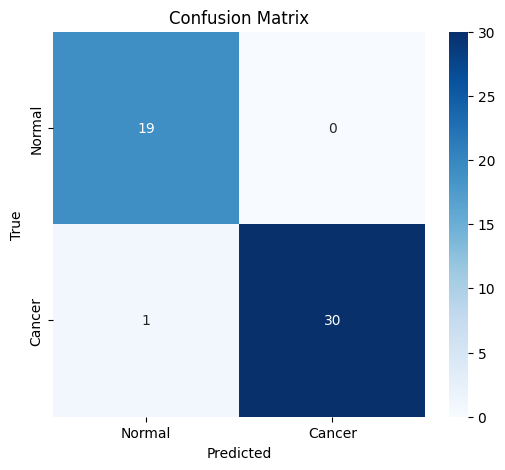

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Step 7: Evaluate the Model and Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)  # Define conf_matrix here

# Figure 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show
# plt.close()
# print("Confusion matrix figure saved as 'confusion_matrix.png'.")

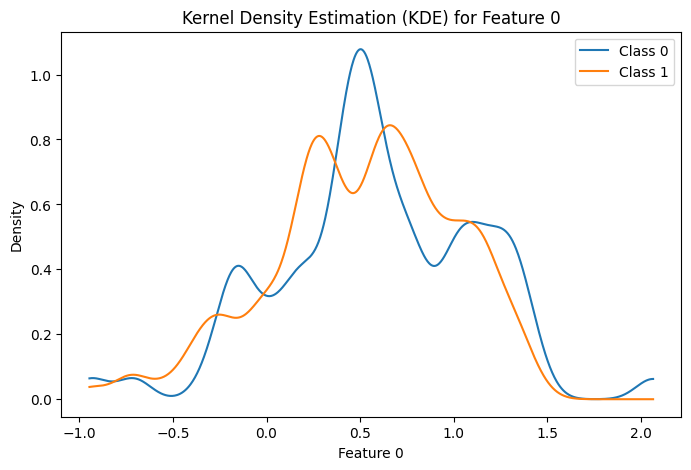

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_kde(classifier, feature_idx, X_train, y_train):
    x_range = np.linspace(X_train[:, feature_idx].min(), X_train[:, feature_idx].max(), 1000).reshape(-1, 1)
    
    plt.figure(figsize=(8, 5))
    
    for c in classifier.classes:
        if classifier.kde_models[c] is None:
            continue
        
        kde = classifier.kde_models[c][feature_idx]
        log_density = kde.score_samples(x_range)
        density = np.exp(log_density)
        
        plt.plot(x_range, density, label=f'Class {c}')
    
    plt.xlabel(f'Feature {feature_idx}')
    plt.ylabel('Density')
    plt.title(f'Kernel Density Estimation (KDE) for Feature {feature_idx}')
    plt.legend()
    plt.show()

# Example: Plot KDE for feature 0
plot_kde(classifier, feature_idx=0, X_train=Train_features, y_train=y_train)


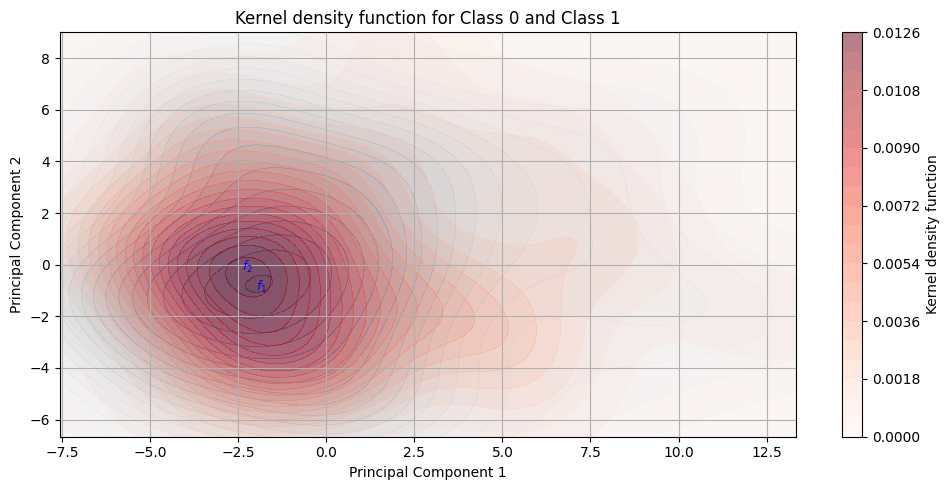

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA

# Giả lập lại dữ liệu nếu cần
np.random.seed(0)
X = Train_features
y = y_train

# Lấy dữ liệu của từng class
class0_data = X[y == 0]
class1_data = X[y == 1]

# Tiến hành PCA để giảm chiều dữ liệu
pca = PCA(n_components=2)  # Chọn 2 thành phần chính để giảm chiều xuống 2D
X_class0_pca = pca.fit_transform(class0_data)
X_class1_pca = pca.fit_transform(class1_data)

# Tính KDE bằng scipy
kde_class0 = gaussian_kde(X_class0_pca.T)  # Sử dụng dữ liệu đã giảm chiều (chuyển vị)
kde_class1 = gaussian_kde(X_class1_pca.T)

# Tạo một lưới 2D (meshgrid) cho các giá trị của x và y
x_min, x_max = np.min(X_class0_pca[:, 0]), np.max(X_class0_pca[:, 0])
y_min, y_max = np.min(X_class0_pca[:, 1]), np.max(X_class0_pca[:, 1])
x_range, y_range = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Làm phẳng lưới 2D thành một mảng 1D để tính KDE
grid_points = np.vstack([x_range.ravel(), y_range.ravel()])

# Tính giá trị KDE cho lưới điểm 2D
kde_vals_class0 = kde_class0(grid_points)
kde_vals_class1 = kde_class1(grid_points)

# Đưa các giá trị KDE vào lại dạng lưới 2D để vẽ
kde_vals_class0_2d = kde_vals_class0.reshape(x_range.shape)
kde_vals_class1_2d = kde_vals_class1.reshape(x_range.shape)

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))

# Vẽ lớp KDE Class 0 và Class 1
cp0 = plt.contourf(x_range, y_range, kde_vals_class0_2d, levels=20, cmap='Blues', alpha=0.5)
cp1 = plt.contourf(x_range, y_range, kde_vals_class1_2d, levels=20, cmap='Reds', alpha=0.5)

# Thêm nhãn cho Class 0 và Class 1
plt.title("Kernel density function for Class 0 and Class 1")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")

# Thêm thanh màu (colorbar)
plt.colorbar(label="Kernel density function")

# Thêm text vào plot cho KDE1 và KDE2
plt.text(-2.0, -1, '$f_1$', color='blue', fontsize=9)
plt.text(-2.4, -0.25, '$f_2$', color='blue', fontsize=9)

# Hiển thị lưới và điều chỉnh bố cục
plt.grid(True)
plt.tight_layout()

# Lưu và hiển thị đồ thị
plt.savefig('2DKDF_with_labels_in_plot.png')
plt.show()


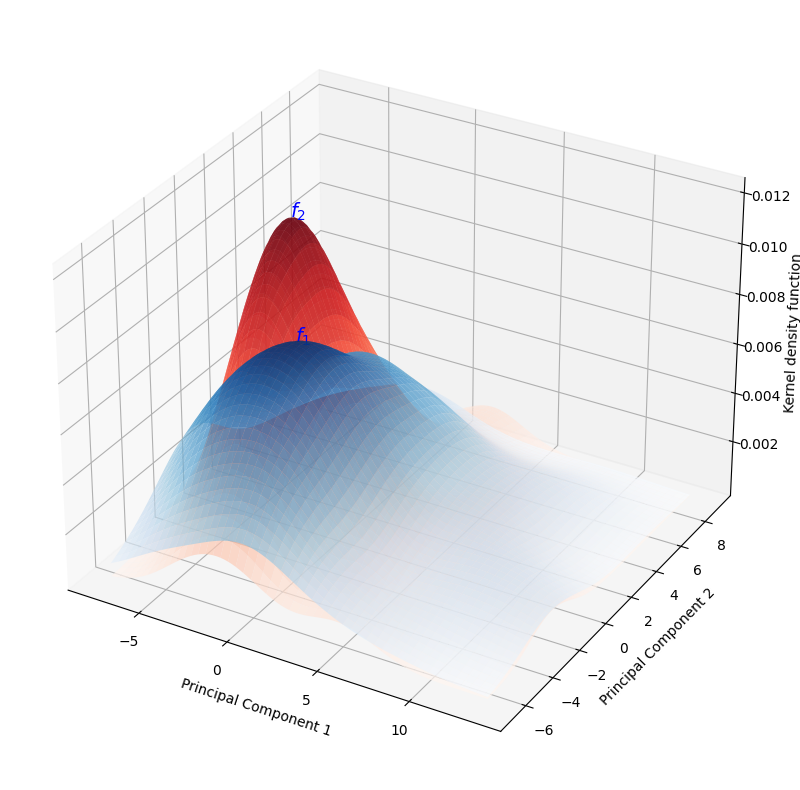

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Giả lập lại dữ liệu nếu cần
np.random.seed(0)
X = Train_features
y = y_train

# Lấy dữ liệu của từng class
class0_data = X[y == 0]
class1_data = X[y == 1]

# Tiến hành PCA để giảm chiều dữ liệu
pca = PCA(n_components=2)  # Chọn 2 thành phần chính để giảm chiều xuống 2D
X_class0_pca = pca.fit_transform(class0_data)
X_class1_pca = pca.fit_transform(class1_data)

# Tính KDE bằng scipy
kde_class0 = gaussian_kde(X_class0_pca.T)  # Sử dụng dữ liệu đã giảm chiều (chuyển vị)
kde_class1 = gaussian_kde(X_class1_pca.T)

# Tạo một lưới 2D (meshgrid) cho các giá trị của x và y
x_min, x_max = np.min(X_class0_pca[:, 0]), np.max(X_class0_pca[:, 0])
y_min, y_max = np.min(X_class0_pca[:, 1]), np.max(X_class0_pca[:, 1])
x_range, y_range = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Làm phẳng lưới 2D thành một mảng 1D để tính KDE
grid_points = np.vstack([x_range.ravel(), y_range.ravel()])

# Tính giá trị KDE cho lưới điểm 2D
kde_vals_class0 = kde_class0(grid_points)
kde_vals_class1 = kde_class1(grid_points)

# Đưa các giá trị KDE vào lại dạng lưới 2D để vẽ
kde_vals_class0_2d = kde_vals_class0.reshape(x_range.shape)
kde_vals_class1_2d = kde_vals_class1.reshape(x_range.shape)

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Tạo mặt phẳng 3D cho KDE Class 0
ax.plot_surface(x_range, y_range, kde_vals_class0_2d, cmap='Blues', alpha=0.7)

# Tạo mặt phẳng 3D cho KDE Class 1
ax.plot_surface(x_range, y_range, kde_vals_class1_2d, cmap='Reds', alpha=0.7)

#ax.set_title("KDE for Class 0 and Class 1")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Kernel density function")
# Thêm label cho KDE1 và KDE2
ax.text(-2, -0.5, np.max(kde_vals_class0_2d), "$f_1$", color="blue", fontsize=14, weight='bold')
ax.text(-2.3, -0.3, np.max(kde_vals_class1_2d), "$f_2$", color="blue", fontsize=14, weight='bold')

plt.tight_layout()
plt.savefig('2DKDF2b.png')
plt.show()


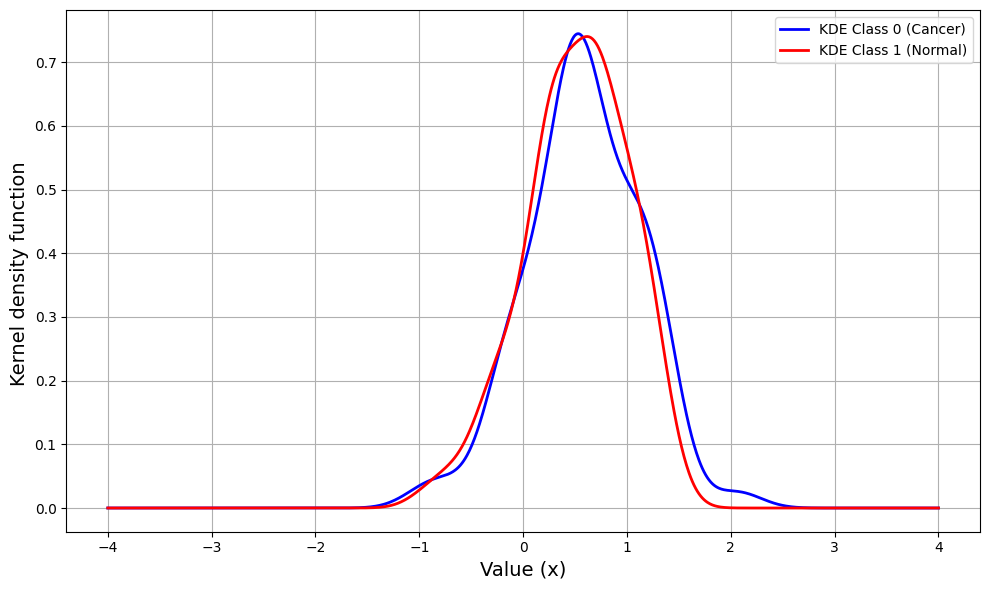

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Giả lập lại dữ liệu nếu cần
np.random.seed(0)
X = Train_features
y = y_train

# Lấy dữ liệu của từng class (1D trong trường hợp này)
class0_data = X[y == 0]
class1_data = X[y == 1]

# Chọn một chiều dữ liệu (VD: sử dụng chiều đầu tiên của dữ liệu)
class0_data_1d = class0_data[:, 0]  # Chọn chiều đầu tiên
class1_data_1d = class1_data[:, 0]  # Chọn chiều đầu tiên

# Tính KDE cho mỗi class
kde_class0 = gaussian_kde(class0_data_1d)
kde_class1 = gaussian_kde(class1_data_1d)

# Tạo lưới điểm cho đồ thị
x_range = np.linspace(-4, 4, 1000)

# Tính giá trị KDE cho lưới điểm
kde_vals_class0 = kde_class0(x_range)
kde_vals_class1 = kde_class1(x_range)

# Vẽ đồ thị 1D KDE
plt.figure(figsize=(10, 6))
plt.plot(x_range, kde_vals_class0, label='KDE Class 0 (Cancer)', color='blue', linewidth=2)
plt.plot(x_range, kde_vals_class1, label='KDE Class 1 (Normal)', color='red', linewidth=2)

# Thêm nhãn và tiêu đề
#plt.title("Kernel density function for Class 0 (Cancer) and Class 1 (Normal)", fontsize=16)
plt.xlabel("Value (x)", fontsize=14)
plt.ylabel("Kernel density function ", fontsize=14)
plt.legend()

# Hiển thị đồ thị
plt.grid(True)
plt.tight_layout()
plt.savefig('1DKDF.png')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_avg_kde(classifier, X_train, num_features=768, num_points=1000):
    # Xác định range dùng chung cho tất cả feature
    min_val = X_train.min()
    max_val = X_train.max()
    x_range = np.linspace(min_val, max_val, num_points).reshape(-1, 1)
    
    plt.figure(figsize=(8, 5))

    for c in classifier.classes:
        avg_density = np.zeros_like(x_range.flatten())
        valid_feature_count = 0

        for feature_idx in range(num_features):
            kde = classifier.kde_models[c][feature_idx]
            if kde is None:
                continue

            log_density = kde.score_samples(x_range)
            density = np.exp(log_density)
            avg_density += density
            valid_feature_count += 1

        if valid_feature_count > 0:
            avg_density /= valid_feature_count
            plt.plot(x_range, avg_density, label=f'Class {c}')
    
    plt.xlabel('Feature Value')
    plt.ylabel('Average Density')
    plt.title('Average KDE over 768 Features')
    plt.legend()
    plt.grid(True)
    plt.show()

# Gọi hàm để vẽ KDE trung bình cho 768 feature
plot_avg_kde(classifier, X_train=Train_features, num_features=768)


In [ ]:
import matplotlib.pyplot as plt

def plot_prior_pie(classifier):
    plt.figure(figsize=(6, 6))
    
    # Replace 0 and 1 with "Normal" and "Cancer"
    labels = ['Normal' if c == 1 else 'Cancer' for c in classifier.priors.keys()]
    sizes = list(classifier.priors.values())

    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=plt.cm.Paired.colors, startangle=140)
    plt.title("Prior Probability")
    plt.savefig('Prior_Probability.png', dpi=300, bbox_inches='tight')  
    plt.show()

# Example usage
plot_prior_pie(classifier)


**2. Naive bayes**

In [ ]:
st=time.time()
# Step 5: Train a Naive Bayes Classifier  
classifier = GaussianNB()  
classifier.fit(Train_features,y_train)  # Training the classifier  

# Step 6: Make Predictions  
y_pred = classifier.predict(Test_features)  

# Step 7: Evaluate the Model  
print("Accuracy:", accuracy_score(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
nd=time.time()
print("Thoi gian thu thi", nd-st)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Step 7: Evaluate the Model and Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)  # Define conf_matrix here

# Figure 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show
# plt.close()
# print("Confusion matrix figure saved as 'confusion_matrix.png'.")

In [ ]:
# Step 8: Show the locations of errors (misclassifications) and their classes
error_indices = (y_test != y_pred)  # Boolean array where True means misclassified

# Display the misclassified indices and their true/predicted labels
for idx in error_indices.nonzero()[0]:  # Loop through misclassified indices
    print(f"Index: {idx}, True Label: {y_test[idx]}, Predicted Label: {y_pred[idx]}")


**3. Logistic regression**

In [ ]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Bắt đầu đo thời gian
st = time.time()

# Step 5: Train a Logistic Regression Classifier  
classifier = LogisticRegression(max_iter=1000)  # Tạo đối tượng LogisticRegression, điều chỉnh max_iter nếu cần thiết  
classifier.fit(Train_features, y_train)  # Huấn luyện mô hình

# Step 6: Make Predictions  
y_pred = classifier.predict(Test_features)  # Dự đoán với dữ liệu kiểm tra

# Step 7: Evaluate the Model  
print("Accuracy:", accuracy_score(y_test, y_pred))  # Đánh giá độ chính xác
print(classification_report(y_test, y_pred))  # In báo cáo phân loại với các chỉ số chính

# Kết thúc đo thời gian
nd = time.time()
print("Thời gian thực thi:", nd - st)  # In ra thời gian thực thi


**4. XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import time
st=time.time()
# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test_encoded = label_encoder.transform(y_test)  # Encoding test labels

# Step 5: Train an XGBoost Classifier
classifier = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
classifier.fit(Train_features, y_train_encoded)  # Training the classifier with encoded labels  

# Step 6: Make Predictions
y_pred_encoded = classifier.predict(Test_features)

# Step 7: Decode predictions back to original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Step 8: Evaluate the Model
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))  # Compare with encoded test labels
print(classification_report(y_test_encoded, y_pred))  # Use encoded labels for report
nd=time.time()
print("Thoi gian thu thi", nd-st)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Step 7: Evaluate the Model and Compute Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)  # Define conf_matrix here

# Figure 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show
# plt.close()
# print("Confusion matrix figure saved as 'confusion_matrix.png'.")

**5. So sánh với thuật toán CNN**

In [ ]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
st=time.time()
# --- Step 1: Load and preprocess images from file paths ---
def load_images(image_paths, target_size=(64, 64)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        img = cv2.resize(img, target_size)
        img = img / 255.0  # Normalize to [0,1]
        images.append(img)
    return np.array(images)

# Create train-test split  
X_train, X_test, y_train, y_test = train_test_split(  
    image_paths,  
    labels,  
    test_size=0.2,  # 20% of data will be used as test set  
    random_state=42,  # For reproducibility 
) 
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Encoding train labels
y_test = label_encoder.transform(y_test)  # Encoding test labels


# Convert to categorical (one-hot encoding)
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# --- Step 5: Load actual image data ---
x_train = load_images(X_train)
x_test = load_images(X_test)

# --- Step 6: Build CNN model ---
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# --- Step 7: Train the model ---
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# --- Step 8: Evaluate the model ---
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\n🎯 Test Accuracy: {test_acc:.4f}")
nd=time.time()
print("Thoi gian thu thi", nd-st)

# --- Step 9: Plot training history ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()